# Import libs

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
SEED = 38

def set_seed(seed=SEED):
  np.random.seed(seed)
  random.seed(seed)
  tf.random.set_seed(seed)

set_seed()

# Extracting data

In [ ]:
!tar -xf cats_dogs_dataset.tar -C /content/

# Preprocessing

In [ ]:
PATH = '/content/cats_dogs_dataset/'

IMG_SIZE = (224, 224)
EPOCHS = 60
BATCH_SIZE = 128

In [ ]:
train_pics_paths = sorted(glob(PATH+'train/*.jpg'))
train_annot_paths = sorted(glob(PATH+'train/*.txt'))

valid_pics_paths = sorted(glob(PATH+'valid/*.jpg'))
valid_annot_paths = sorted(glob(PATH+'valid/*.txt'))

In [ ]:
def load_image(path, new_size, get_hw=False):
  img = cv2.imread(path, cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # get height and width for the next function
  if get_hw:
    h = img.shape[0]
    w = img.shape[1]
  img = cv2.resize(img, new_size, 3)
  img = img.reshape(-1, new_size[0], new_size[1], 3).astype(np.float32) / 255.

  if get_hw:
    return img, h, w
  else:
    return img

In [ ]:
def prepare_dataset(img_list, path_list, new_size):
  df = pd.DataFrame()
  columns = ['class', 'xmin', 'ymin', 'xmax', 'ymax']
  for file_path in path_list:
    tmp = pd.read_csv(file_path, names=columns, sep=' ')
    df = pd.concat([df, tmp], ignore_index=True)
  df['class'] = df['class'].replace(2, 0)
  labels = df['class'].values
  height = []
  width = []
  x = np.zeros((len(img_list), new_size[0], new_size[1], 3), dtype=np.float32)
  y = np.zeros((len(path_list), 2, 5), dtype=np.float32)
  y[:, :, 1:] = -1
  for i, pic in enumerate(img_list):
    img, h, w = load_image(pic, new_size, get_hw=True)
    height.append(h)
    width.append(w)
    x[i] = img
  for i, row in df.iterrows():
    x_scale = new_size[0] / width[i]
    y_scale = new_size[1] / height[i]
    x0 = int(np.round(row.xmin * x_scale)) / new_size[0]
    y0 = int(np.round(row.ymin * y_scale)) / new_size[1]
    x1 = int(np.round(row.xmax * x_scale)) / new_size[0]
    y1 = int(np.round(row.ymax * y_scale)) / new_size[1]
    y[i][labels[i]] = [1., x0, y0, x1, y1]

  return x, y

In [ ]:
x_train, y_train = prepare_dataset(
    train_pics_paths, train_annot_paths, IMG_SIZE)
x_test, y_test = prepare_dataset(valid_pics_paths, valid_annot_paths, IMG_SIZE)

In [ ]:
# shuffle data
x_train, y_train = shuffle(x_train, y_train, random_state=SEED)

In [ ]:
def show_predict(img, pred, new_size, predict=False, 
                 show_class=False, return_image=False):

  if predict:
    img = img[0, ...]
    img = cv2.resize(img, (new_size[0], new_size[1]))

  if np.argmax(pred) == 5:
    x0, y0, x1, y1 = pred[1, 1], pred[1, 2], pred[1, 3], pred[1, 4]
    label = 'Cat'
  elif np.argmax(pred) == 0:
    x0, y0, x1, y1 = pred[0, 1], pred[0, 2], pred[0, 3], pred[0, 4]
    label = 'Dog'

  x = int(x0 * new_size[1])
  y = int(y0 * new_size[0])
  x1 = int(x1 * new_size[1])
  y1 = int(y1 * new_size[0])
  image = cv2.rectangle(img, (x, y), (x1, y1), (0, 1, 0), 2)
  if show_class:
    image = cv2.putText(
        image,
        label,
        (x, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        (1, 0, 0),
        2
    )
    plt.imshow(image)
  else:
    plt.title(label)
    plt.imshow(image)

  if return_image:
    return image

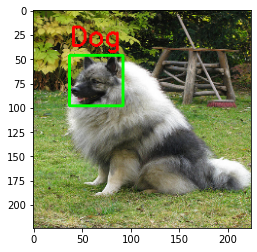

In [ ]:
i = np.random.randint(0, x_train.shape[0])
show_predict(x_train[i], y_train[i], IMG_SIZE, show_class=True)

# Model №1 - Transfer Learning (freeze layers)

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

input = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

x = base_model(input)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(2*5)(x)

output = tf.reshape(x, (-1, 2*5//5, 5))

tl_f_model = tf.keras.Model(inputs=input, outputs=output)

In [ ]:
def loss_cls(labels, logits):
    logits_cls = logits[:,:,0]
    labels_cls = labels[:,:,0]
    return tf.nn.sigmoid_cross_entropy_with_logits(labels_cls, logits_cls)

def loss_box(labels, logits):
    logits_box = logits[:,:,1:]
    labels_box = labels[:,:,1:]
    return tf.keras.losses.mean_squared_error(labels_box, logits_box)

LAMBDA = 7.0
def od_loss(labels, logits):
    return loss_cls(labels, logits) + LAMBDA * loss_box(labels, logits)

In [ ]:
tl_f_model.compile(
    optimizer=tf.keras.optimizers.Adam(amsgrad=True),
    loss=od_loss
    )

tl_f_model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    )

Epoch 1/60
24/24 [==============================] - 38s 151ms/step - loss: 4.5800
Epoch 2/60
24/24 [==============================] - 3s 141ms/step - loss: 3.8634
Epoch 3/60
24/24 [==============================] - 3s 143ms/step - loss: 3.8599
Epoch 4/60
24/24 [==============================] - 3s 142ms/step - loss: 3.8368
Epoch 5/60
24/24 [==============================] - 3s 143ms/step - loss: 3.7981
Epoch 6/60
24/24 [==============================] - 3s 145ms/step - loss: 3.7501
Epoch 7/60
24/24 [==============================] - 3s 141ms/step - loss: 3.8098
Epoch 8/60
24/24 [==============================] - 3s 144ms/step - loss: 3.8140
Epoch 9/60
24/24 [==============================] - 3s 141ms/step - loss: 3.8025
Epoch 10/60
24/24 [==============================] - 3s 142ms/step - loss: 3.8617
Epoch 11/60
24/24 [==============================] - 3s 142ms/step - loss: 3.7986
Epoch 12/60
24/24 [==============================] - 3s 144ms/step - loss: 3.7749
Epoch 13/60
24/24 [=====

In [ ]:
def get_results(model, test_images, show_train_acc=True):
  import time
  start = time.time()
  pred = model.predict(test_images)
  finish = time.time()

  y_true = []
  for i in range(len(y_test)):
    array = y_test[i]
    
    if array[1, 0] > array[0, 0]:
      y_true.append(1)
    elif array[0, 0] > array[1, 0]:
      y_true.append(0)

  if show_train_acc:
    pred_train = model.predict(x_train)
    x_true = []
    for i in range(len(y_train)):
      array = y_train[i]
      
      if array[1, 0] > array[0, 0]:
        x_true.append(1)
      elif array[0, 0] > array[1, 0]:
        x_true.append(0)

    x_pred = []
    for i in range(len(pred_train)):
      array = pred_train[i]

      if array[1, 0] > array[0, 0]:
        x_pred.append(1)
      elif array[0, 0] > array[1, 0]:
        x_pred.append(0)  

  y_pred = []
  for i in range(len(pred)):
    array = pred[i]
    
    if array[1, 0] > array[0, 0]:
      y_pred.append(1)
    elif array[0, 0] > array[1, 0]:
      y_pred.append(0)

  miou = tf.keras.metrics.MeanIoU(num_classes=2)
  miou.update_state(y_true, y_pred)
  miou_acc = miou.result().numpy()
  miou_acc = np.round(miou_acc * 100, 2)
  
  test_acc = tf.keras.metrics.Accuracy()
  test_acc.update_state(y_true, y_pred)
  test_class_acc = test_acc.result().numpy()
  test_class_acc = np.round(test_class_acc * 100, 2)

  if show_train_acc:
    train_acc = tf.keras.metrics.Accuracy()
    train_acc.update_state(x_true, x_pred)
    train_class_acc = train_acc.result().numpy()
    train_class_acc = np.round(train_class_acc * 100, 2)

  time = ((finish - start) * 10**3) / len(test_images)
  time = np.round(time, 2)

  print(f'mIou: {miou_acc} %')
  if show_train_acc:
    print(f'Точность на трейне: {train_class_acc} %')
  print(f'Точность на тесте: {test_class_acc} %')
  print(f'Время одного инференс прохода: {time} ms')
  print(f'Размер тренировочного датасета: {len(x_train)}')
  print(f'Размер тестового датасета: {len(test_images)}')

In [ ]:
get_results(tl_f_model, x_test)

mIou: 34.25 %
Точность на трейне: 69.48 %
Точность на тесте: 68.5 %
Время одного инференс прохода: 4.63 ms
Размер тренировочного датасета: 2985
Размер тестового датасета: 400


# Model №2 - Transfer Learning (unfreeze layers)

In [ ]:
base_model.trainable = True

input = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

x = base_model(input)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(2*5)(x)

output = tf.reshape(x, (-1, 2*5//5, 5))

tl_model = tf.keras.Model(inputs=input, outputs=output)

In [ ]:
tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(amsgrad=True),
    loss=od_loss
    )

tl_model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    )

Epoch 1/60
24/24 [==============================] - 27s 784ms/step - loss: 2.6600
Epoch 2/60
24/24 [==============================] - 18s 766ms/step - loss: 0.3941
Epoch 3/60
24/24 [==============================] - 19s 770ms/step - loss: 0.1853
Epoch 4/60
24/24 [==============================] - 19s 769ms/step - loss: 0.1746
Epoch 5/60
24/24 [==============================] - 19s 778ms/step - loss: 0.0909
Epoch 6/60
24/24 [==============================] - 19s 780ms/step - loss: 0.0965
Epoch 7/60
24/24 [==============================] - 19s 780ms/step - loss: 0.1463
Epoch 8/60
24/24 [==============================] - 18s 769ms/step - loss: 0.0875
Epoch 9/60
24/24 [==============================] - 19s 770ms/step - loss: 0.0666
Epoch 10/60
24/24 [==============================] - 19s 779ms/step - loss: 0.0454
Epoch 11/60
24/24 [==============================] - 19s 773ms/step - loss: 0.0602
Epoch 12/60
24/24 [==============================] - 18s 765ms/step - loss: 0.0638
Epoch 13/60
2

In [ ]:
get_results(tl_model, x_test)

mIou: 34.25 %
Точность на трейне: 69.51 %
Точность на тесте: 68.5 %
Время одного инференс прохода: 3.98 ms
Размер тренировочного датасета: 2985
Размер тестового датасета: 400


# Model №3 - Simple model

In [ ]:
input = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

x = tf.keras.layers.Conv2D(
    filters=32, kernel_size=(3, 3), activation='relu', padding='same')(input)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(
    filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(
    filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(
    filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(2*5)(x)

output = tf.reshape(x, (-1, 2*5//5, 5))

original_model = tf.keras.Model(inputs=input, outputs=output)

In [ ]:
original_model.compile(
    optimizer=tf.keras.optimizers.Adam(amsgrad=True),
    loss=od_loss
    )

original_model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    )

Epoch 1/60
24/24 [==============================] - 42s 249ms/step - loss: 4.1723
Epoch 2/60
24/24 [==============================] - 5s 198ms/step - loss: 3.7523
Epoch 3/60
24/24 [==============================] - 5s 199ms/step - loss: 3.7565
Epoch 4/60
24/24 [==============================] - 5s 200ms/step - loss: 3.7382
Epoch 5/60
24/24 [==============================] - 5s 199ms/step - loss: 3.6199
Epoch 6/60
24/24 [==============================] - 5s 197ms/step - loss: 3.5254
Epoch 7/60
24/24 [==============================] - 5s 196ms/step - loss: 3.6305
Epoch 8/60
24/24 [==============================] - 5s 198ms/step - loss: 3.5545
Epoch 9/60
24/24 [==============================] - 5s 198ms/step - loss: 3.5168
Epoch 10/60
24/24 [==============================] - 5s 201ms/step - loss: 3.5112
Epoch 11/60
24/24 [==============================] - 5s 201ms/step - loss: 3.5576
Epoch 12/60
24/24 [==============================] - 5s 201ms/step - loss: 3.4333
Epoch 13/60
24/24 [=====

In [ ]:
get_results(original_model, x_test)

mIou: 68.72 %
Точность на трейне: 98.69 %
Точность на тесте: 84.25 %
Время одного инференс прохода: 2.79 ms
Размер тренировочного датасета: 2985
Размер тестового датасета: 400


# Model №4 - Simple model + augs

In [ ]:
input = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

x = preprocessing.RandomFlip('horizontal')(input)
x = preprocessing.RandomRotation(.3)(x)
x = preprocessing.RandomZoom(.3)(x)
x = tf.keras.layers.Conv2D(
    filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(
    filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(
    filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(
    filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(2*5)(x)

output = tf.reshape(x, (-1, 2*5//5, 5))

original_model_aug = tf.keras.Model(inputs=input, outputs=output)

In [ ]:
original_model_aug.compile(
    optimizer=tf.keras.optimizers.Adam(amsgrad=True),
    loss=od_loss
    )

original_model_aug.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    )

Epoch 1/60
24/24 [==============================] - 4s 126ms/step - loss: 4.2859
Epoch 2/60
24/24 [==============================] - 3s 125ms/step - loss: 3.8042
Epoch 3/60
24/24 [==============================] - 3s 125ms/step - loss: 3.8231
Epoch 4/60
24/24 [==============================] - 3s 125ms/step - loss: 3.7689
Epoch 5/60
24/24 [==============================] - 3s 124ms/step - loss: 3.7186
Epoch 6/60
24/24 [==============================] - 3s 126ms/step - loss: 3.6834
Epoch 7/60
24/24 [==============================] - 3s 124ms/step - loss: 3.7264
Epoch 8/60
24/24 [==============================] - 3s 125ms/step - loss: 3.6470
Epoch 9/60
24/24 [==============================] - 3s 125ms/step - loss: 3.5961
Epoch 10/60
24/24 [==============================] - 3s 124ms/step - loss: 3.6634
Epoch 11/60
24/24 [==============================] - 3s 122ms/step - loss: 3.6071
Epoch 12/60
24/24 [==============================] - 3s 125ms/step - loss: 3.5839
Epoch 13/60
24/24 [======

In [ ]:
get_results(original_model_aug, x_test)

mIou: 48.53 %
Точность на трейне: 73.74 %
Точность на тесте: 75.0 %
Время одного инференс прохода: 0.58 ms
Размер тренировочного датасета: 2985
Размер тестового датасета: 400


# Model №5 - Simple model + dropout

In [ ]:
input = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

x = preprocessing.RandomFlip('horizontal')(input)
x = preprocessing.RandomRotation(.3)(x)
x = preprocessing.RandomZoom(.3)(x)
x = tf.keras.layers.Conv2D(
    filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(
    filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(
    filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(
    filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(.3)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(.3)(x)
x = tf.keras.layers.Dense(2*5)(x)

output = tf.reshape(x, (-1, 2*5//5, 5))

original_model_do = tf.keras.Model(inputs=input, outputs=output)

In [ ]:
original_model_do.compile(
    optimizer=tf.keras.optimizers.Adam(amsgrad=True),
    loss=od_loss
    )

original_model_do.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    )

Epoch 1/60
24/24 [==============================] - 6s 215ms/step - loss: 4.4049
Epoch 2/60
24/24 [==============================] - 5s 214ms/step - loss: 3.9439
Epoch 3/60
24/24 [==============================] - 5s 212ms/step - loss: 3.8927
Epoch 4/60
24/24 [==============================] - 5s 215ms/step - loss: 3.8855
Epoch 5/60
24/24 [==============================] - 5s 213ms/step - loss: 3.7625
Epoch 6/60
24/24 [==============================] - 5s 215ms/step - loss: 3.7144
Epoch 7/60
24/24 [==============================] - 5s 212ms/step - loss: 3.7873
Epoch 8/60
24/24 [==============================] - 5s 214ms/step - loss: 3.7067
Epoch 9/60
24/24 [==============================] - 5s 213ms/step - loss: 3.6875
Epoch 10/60
24/24 [==============================] - 5s 213ms/step - loss: 3.6967
Epoch 11/60
24/24 [==============================] - 5s 212ms/step - loss: 3.6367
Epoch 12/60
24/24 [==============================] - 5s 214ms/step - loss: 3.6498
Epoch 13/60
24/24 [======

In [ ]:
get_results(original_model_do, x_test)

mIou: 62.75 %
Точность на трейне: 78.46 %
Точность на тесте: 79.75 %
Время одного инференс прохода: 0.7 ms
Размер тренировочного датасета: 2985
Размер тестового датасета: 400


# Bonus

In [ ]:
def predict_one_image(model, image_path, image_name, save_image=True):
  image = load_image(image_path, IMG_SIZE)
  pred = model.predict(image)[0]
  if save_image:
    image_bb = show_predict(
      image, pred, IMG_SIZE, predict=True, show_class=True, return_image=True)
    cv2.imwrite(image_name + '.png', image_bb)
  else:
    show_predict(image, pred, IMG_SIZE, predict=True)

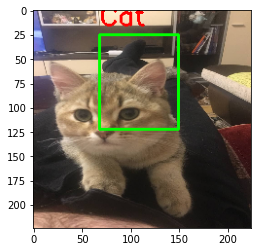

In [ ]:
predict_one_image(original_model, '/content/kitty_a_2.jpg', 'cat_1')

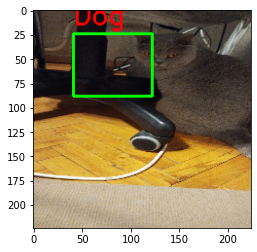

In [ ]:
predict_one_image(original_model, '/content/kitty_m_2.jpeg', 'cat_2')